In [11]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# SPES Exploration
This is a Single Pulse exploration notebook. The goal here is interact with basic I/O for SPES data and prototype some methods for CRP parameterization 

In [19]:
# Basic viz
DATA_FOLDER = '/mnt/ernie_main/000_Data/SPES/data/preprocessed/'
files = []
spes_dfs = []
for pulse in range(1,11):
    file = f'Epat26/Epat26_CCEP_single_pulses/Epat26_LAC3-LAC4_5mA_pulse_{pulse}.mat'
    files.append(file)
    spes_trial = loadmat(os.path.join(DATA_FOLDER, file))
    fs = spes_trial['fs'][0][0]
    full_train = spes_trial["pulse"]
    labels  = [l[0] for l in spes_trial['labels'][0]]
    df = construct_spes_df(full_train, labels,fs)
    df['trial'] = pulse
    spes_dfs.append(df)
stim_contact = get_stim(files[0])
spes_dfs = pd.concat(spes_dfs)

In [17]:
stim_contact

['CCEP']

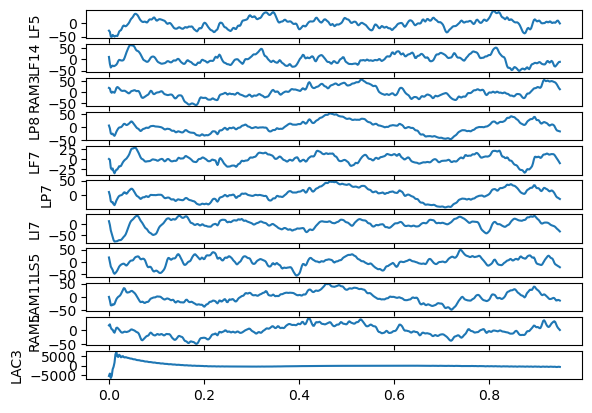

In [20]:
spes_df = spes_dfs[spes_dfs.trial==5]
rind10 = np.random.random_integers(0,len(labels)-1,10)
chs_to_plot = list(spes_df.columns[rind10])
if stim_contact[0] not in chs_to_plot:
    chs_to_plot.append(stim_contact[0])
plot_channels(spes_df, chs_to_plot)

In [21]:
t_ix = lambda t: round(t*fs)

In [42]:
resp_region = 'LF5'
df = spes_dfs[[resp_region,'trial']]
vals = spes_df.columns[0:-1]
region_df = spes_dfs.pivot(columns='trial',values=vals)
region_df

LTP1                                                         \
trial            1          2          3          4          5          6    
0.000000  60.308583  50.720474  68.003125  34.787388  21.997528 -44.458640   
0.001953  43.048149  52.425718  60.963669  28.144969   2.624011 -49.174865   
0.003906  19.408163  46.640749  50.700970  13.671220 -28.867444 -62.231680   
0.005859  11.468665  52.987304  53.680238  11.907568 -43.021948 -59.774127   
0.007812   6.249884  60.918122  54.377371   9.322040 -49.566945 -52.467961   
...             ...        ...        ...        ...        ...        ...   
0.941406 -44.328894  50.168408  36.273247 -48.550455  -8.363032  29.804686   
0.943359 -41.627522  52.830288  33.482808 -48.452366 -10.099305  27.531807   
0.945312 -35.302950  56.174327  24.724890 -44.478523 -11.833468  29.911082   
0.947266 -23.196330  55.993221  11.424696 -38.737531 -14.878820  31.670433   
0.949219  -8.694869  47.150151  -2.128403 -35.298832 -14.461209  29.176088   

                                                      ...      RAM14  \
trial            7          8          9          10  ...         1    
0.000000  44.729037  -7.201717  28.271788 -35.514540  ...  40.345743   
0.001953  35.254417  -9.893207  17.166144 -40.665518  ...  35.104398   
0.003906  12.424398 -26.360339  -1.430427 -63.706986  ...  23.520611   
0.005859   9.521196 -26.490630  -5.205940 -71.510551  ...  16.809706   
0.007812  16.559916 -15.289231  -5.651825 -68.736912  ...  14.143412   
...             ...        ...        ...        ...  ...        ...   
0.941406  42.941326  54.274840  36.643547   5.280514  ... -33.548214   
0.943359  44.073770  54.038225  33.411927   0.991262  ... -29.676610   
0.945312  44.433433  51.616877  28.125297  -2.502159  ... -26.409421   
0.947266  42.165341  49.427902  22.290248  -5.186894  ... -23.751122   
0.949219  36.033042  50.227640  19.465706  -8.104097  ... -22.490681   

                                                                            \
trial            2          3          4          5          6          7    
0.000000 -12.910328  32.000839  -2.969836  -2.751061  27.414672  15.799649   
0.001953  -9.767279  32.054329   2.242913   0.880214  31.169952  18.830733   
0.003906 -15.915107  21.646712  -5.696690  -6.371694  22.631921   8.890827   
0.005859 -20.161885  13.042072 -11.083693 -11.813965  16.229670   0.449338   
0.007812 -19.988153   9.839409  -9.369634 -11.499506  17.820380  -0.057274   
...             ...        ...        ...        ...        ...        ...   
0.941406   1.652078  15.861899 -20.083159  18.871067  50.718877 -17.873928   
0.943359   2.320752  17.423509 -17.134146  16.556230  51.346896 -17.934026   
0.945312   1.004803  16.973236 -13.925451  15.560042  53.761389 -16.676436   
0.947266   0.998845  14.146578 -11.904304  14.947731  58.143452 -15.540117   
0.949219   2.474818  13.678329 -11.184335  14.333226  62.056952 -16.680403   

                                           
trial            8          9          10  
0.000000 -40.821633  18.350569  35.726714  
0.001953 -35.830031  23.254804  37.382234  
0.003906 -42.745561  18.135217  26.860362  
0.005859 -49.645145  13.772711  16.886590  
0.007812 -49.733205  14.846587  13.042043  
...             ...        ...        ...  
0.941406  -5.965355  33.799709 -37.130321  
0.943359 -10.791678  34.782374 -38.682876  
0.945312 -15.076047  36.028477 -40.254931  
0.947266 -15.346770  36.319970 -39.398227  
0.949219 -12.340210  36.345086 -38.193293  

[487 rows x 1480 columns]

<Axes: >

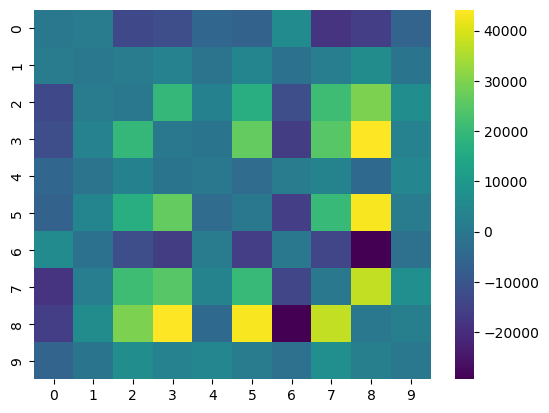

In [36]:
#TODO need to incorporate artifact removal and then work on cross projection. 
#For now, it would be interesting to get global cross projection

_,k = region_df.shape
resp_areas = region_df.values
resp_areas = resp_areas[t_ix(.1):t_ix(.15)]
full_crossproj = resp_areas.T@resp_areas
full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(k)
df_full_crossproj = pd.DataFrame(data=full_crossproj)
sns.heatmap(df_full_crossproj, cmap="viridis")


In [37]:
resp_areas = region_df.values
norm = np.linalg.norm(resp_areas,axis=1)
V_norm =resp_areas/ norm[:,None]

In [38]:
s = t_ix(.025)
cross_dfs = []
#TODO consider adding area relationships
for t in np.linspace(0.05, 0.99,50):
    e = t_ix(t)
    win_len = t - .025
    V = V_norm[s:e]
    V_raw = resp_areas[s:e]
    full_crossproj = V.T@V_raw
    full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(10)
    df = pd.DataFrame(data=full_crossproj.flatten(), columns=['cross_proj'])
    df['win_size'] = win_len
    cross_dfs.append(df)
cross_proj_df = pd.concat(cross_dfs)


<Axes: xlabel='win_size', ylabel='cross_proj'>

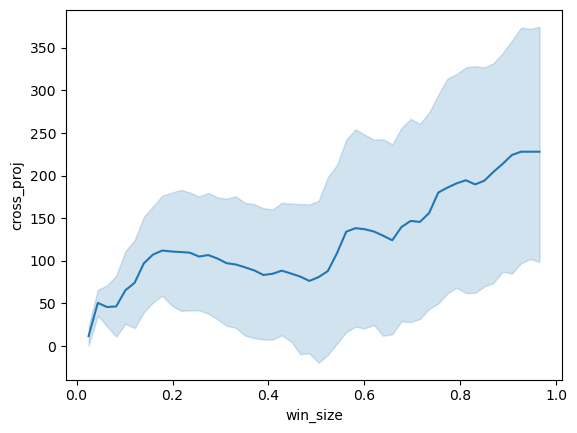

In [39]:
sns.lineplot(data=cross_proj_df, x="win_size", y="cross_proj")

In [18]:
def construct_spes_df(spes_trains, contact_labels, fs):
    assert len(contact_labels) == min(spes_trains.shape)
    if np.argmax(spes_trains.shape) != 0:
        spes_trains = spes_trains.T
    nsamps,ch = spes_trains.shape
    t = np.arange(nsamps)/fs
    df = pd.DataFrame(columns=contact_labels, index =t, data=spes_trains)
    return  df

def get_stim(fname):
    fname = os.path.split(fname)[1]
    bipole = fname.split("_")[1] 
    return bipole.split("-")

def plot_channels(spes_df , channel_list):
    nrows = len(channel_list)
    fig, axes = plt.subplots(nrows=nrows, ncols=1,sharex=True)
    for i,ch in enumerate(channel_list):
        ax = axes[i]
        sns.lineplot(x=spes_df.index, y=spes_df[ch], ax=ax)
    
    